In [ ]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
from typing import Optional
from dm_control.rl.control import PhysicsError
from tqdm import trange
from gymnasium.utils.env_checker import check_env
from joblib import Parallel, delayed, parallel_config
from flygym.examples.vision_connectome_model import (
    NMFRealisticVision,
    visualize_vision,
)
from flygym.examples.head_stabilization import HeadStabilizationInferenceWrapper
from flygym.examples.head_stabilization import get_head_stabilization_model_paths


from flygym import Fly, Camera, Parameters
from flygym.arena import FlatTerrain, BaseArena
from flygym.examples.vision_connectome_model.network import *
from flygym.examples.vision_connectome_model.viz import *
from connectome_behavior import *

In [ ]:
class OptomotorTerrain(FlatTerrain):
    def __init__(
        self,
        n=18,
        height=100,
        distance=12,
        ang_speed=1,
        palette=((0, 0, 0, 1), (1, 1, 1, 1)),
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.height = height
        self.ang_speed = ang_speed

        self.cylinders = []
        self.phase = 0
        self.curr_time = 0

        cylinder_material = self.root_element.asset.add(
            "material", name="cylinder", reflectance=0.1
        )
        init_pos = np.exp(2j * np.pi * np.arange(n) / n) * distance
        radius = np.abs(init_pos[1] - init_pos[0]) / 2
        self.init_pos = init_pos

        for i, pos in enumerate(self.init_pos):
            cylinder = self.root_element.worldbody.add(
                "body",
                name=f"cylinder_{i}",
                mocap=True,
                pos=(pos.real, pos.imag, self.height / 2),
            )

            cylinder.add(
                "geom",
                type="cylinder",
                size=(radius, self.height / 2),
                rgba=palette[i % len(palette)],
                material=cylinder_material,
            )

            self.cylinders.append(cylinder)

        self.birdeye_cam = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam",
            mode="fixed",
            pos=(0, 0, 25),
            euler=(0, 0, 0),
            fovy=45,
        )

    def reset(self, physics):
        """Resets the position of the cylinders and the phase of the grating pattern."""
        self.phase = 0
        self.curr_time = 0

        for i, p in enumerate(self.init_pos):
            physics.bind(self.cylinders[i]).mocap_pos = (
                p.real,
                p.imag,
                self.height / 2,
            )

    def step(self, dt, physics):
        """Steps the phase of the grating pattern and updates the position of the cylinders."""

        if self.curr_time % 1 < 1 / 2:
            self.phase -= dt * self.ang_speed
        else:
            self.phase += dt * self.ang_speed

        self.curr_time += dt

        pos = np.exp(self.phase * 1j) * self.init_pos

        for i, p in enumerate(pos):
            physics.bind(self.cylinders[i]).mocap_pos = (
                p.real,
                p.imag,
                self.height / 2,
            )

In [ ]:

class LoomingTerrain(BaseArena):
    def __init__(
        self,
        move_direction = "towards",
        lateral_magnitude = 2,
        move_speed = 10,
        obj_radius = 4,
        init_ball_pos = (25, 4),
        size = (300, 300),
        friction = (1, 0.005, 0.0001),
    ):
        super().__init__()
        self.init_ball_pos = (*init_ball_pos, obj_radius)
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        self.friction = friction
        self.move_speed = move_speed
        self.curr_time = 0
        self.lateral_magnitude = lateral_magnitude
        self.move_direction = move_direction
        if move_direction == "towards":
            self.x_mult = -1
        elif move_direction == "away":
            self.x_mult = 1
        else:
            raise ValueError("Invalid move_direction")

        # Add ground
        ground_size = [*size, 1]
        chequered = self.root_element.asset.add(
            "texture",
            type="2d",
            builtin="checker",
            width=300,
            height=300,
            rgb1=(0.4, 0.4, 0.4),
            rgb2=(0.5, 0.5, 0.5),
        )
        grid = self.root_element.asset.add(
            "material",
            name="grid",
            texture=chequered,
            texrepeat=(60, 60),
            reflectance=0.1,
        )
        self.root_element.worldbody.add(
            "geom",
            type="plane",
            name="ground",
            material=grid,
            size=ground_size,
            friction=friction,
        )
        self.root_element.worldbody.add("body", name="b_plane")

        # Add ball
        obstacle = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.root_element.worldbody.add(
            "body", name="ball_mocap", mocap=True, pos=self.ball_pos, gravcomp=1
        )
        self.object_body = self.root_element.find("body", "ball_mocap")
        self.object_body.add(
            "geom",
            name="ball",
            type="sphere",
            size=(obj_radius, obj_radius),
            rgba=(0.0, 0.0, 0.0, 1),
            material=obstacle,
        )

        self.birdeye_cam = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam",
            mode="fixed",
            pos=(15, 0, 35),
            euler=(0, 0, 0),
            fovy=45,
        )
    
    def get_spawn_position(self, rel_pos, rel_angle):
        return rel_pos, rel_angle

    def step(self, dt, physics):
        heading_vec = np.array(
            [1.0 * self.lateral_magnitude * self.x_mult, 0]
        )
        #heading_vec /= np.linalg.norm(heading_vec)
        self.ball_pos[:2] += self.move_speed * heading_vec * dt
        physics.bind(self.object_body).mocap_pos = self.ball_pos
        self.curr_time += dt

    def reset(self, physics):
        self.curr_time = 0
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        physics.bind(self.object_body).mocap_pos = self.ball_pos


In [ ]:
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

# fmt: off
cells = [
    "T1", "T2", "T2a", "T3", "T4a", "T4b", "T4c", "T4d", "T5a", "T5b", "T5c", "T5d",
    "Tm1", "Tm2", "Tm3", "Tm4", "Tm5Y", "Tm5a", "Tm5b", "Tm5c", "Tm9", "Tm16", "Tm20",
    "Tm28", "Tm30", "TmY3", "TmY4", "TmY5a", "TmY9", "TmY10", "TmY13", "TmY14", "TmY15",
    "TmY18"
]
# fmt: on

output_dir = Path("./outputs/")
stabilization_model_path, scaler_param_path = get_head_stabilization_model_paths()


def run_simulation(
    fly_behavior,
    arena,
    run_time: float = 1.0,
    head_stabilization_model: Optional[HeadStabilizationInferenceWrapper] = None,
):
    fly = Fly(
        contact_sensor_placements=contact_sensor_placements,
        enable_adhesion=True,
        enable_vision=True,
        vision_refresh_rate=500,
        neck_kp=1000,
        head_stabilization_model=head_stabilization_model,
    )

    cam = Camera(
        fly=fly,
        camera_id="birdeye_cam",
        play_speed=0.2,
        window_size=(800, 608),
        fps=24,
        play_speed_text=False,
    )

    sim = NMFRealisticVision(
        fly=fly,
        cameras=[cam],
        arena=arena,
    )

    obs, info = sim.reset(seed=0)
    obs_hist = []
    info_hist = []
    rendered_image_snapshots = []
    vision_observation_snapshots = []
    nn_activities_snapshots = []
    
    # This array will serve as the basis for the motion of the fly during optomotor response
    turn_bias = np.array([0, 0])
    # Main simulation loop
    for i in trange(int(run_time / sim.timestep)):
        if info["vision_updated"]:
            nn_activities = info["nn_activities"]
            if(fly_behavior == "Immobile"):
                turn_bias = immobile_behavior()
            elif(fly_behavior == "SimpleSTDT4"):
                turn_bias = std_behavior(nn_activities, sim, adaptative = False, t4 = True, t5 = False, tm = False)
            elif(fly_behavior == "SimpleSTDT5"):
                turn_bias = std_behavior(nn_activities, sim, adaptative = False, t4 = False, t5 = True, tm = False)
            elif(fly_behavior == "AdaptativeSTDT4"):
                turn_bias = std_behavior(nn_activities, sim, adaptative = True, t4 = True, t5 = False, tm = False)
            elif(fly_behavior == "AdaptativeSTDT5"):
                turn_bias = std_behavior(nn_activities, sim, adaptative = True, t4 = False, t5 = True, tm = False)
            elif(fly_behavior == "SimpleSTDT45"):
                turn_bias = std_behavior(nn_activities, sim, adaptative = False, t4 = True, t5 = True, tm = False)
            elif(fly_behavior == "AdaptativeSTDT45"):
                turn_bias = std_behavior(nn_activities, sim, adaptative = True, t4 = True, t5 = True, tm = False)
            elif(fly_behavior == "RealisticProportional"):
                turn_bias = std_behavior(nn_activities, sim, adaptative = True, t4 = True, t5 = True, tm = True)
            else:
                print("Error while choosing behavior type.")
                return
            print(turn_bias)

            
        try:
            obs, _, _, _, info = sim.step(action = turn_bias)
        except PhysicsError:
            print("Physics error, ending simulation early")
            break
        obs_hist.append(obs)
        info_hist.append(info)
        rendered_img = sim.render()[0]
        if rendered_img is not None:
            rendered_image_snapshots.append(rendered_img)
            vision_observation_snapshots.append(obs["vision"])
            nn_activities_snapshots.append(info["nn_activities"])

    return {
        "sim": sim,
        "obs_hist": obs_hist,
        "info_hist": info_hist,
        "rendered_image_snapshots": rendered_image_snapshots,
        "vision_observation_snapshots": vision_observation_snapshots,
        "nn_activities_snapshots": nn_activities_snapshots,
    }

 99%|█████████▉| 9880/10000 [16:45<00:12,  9.82it/s]

[-1.2  1.2]


 99%|█████████▉| 9900/10000 [16:47<00:10,  9.82it/s]

[-1.2  1.2]


 99%|█████████▉| 9920/10000 [16:49<00:08,  9.80it/s]

[-1.2  1.2]


 99%|█████████▉| 9940/10000 [16:51<00:06,  9.82it/s]

[-1.2  1.2]


100%|█████████▉| 9960/10000 [16:53<00:04,  9.82it/s]

[-1.2  1.2]


100%|█████████▉| 9980/10000 [16:55<00:02,  9.82it/s]

[-1.2  1.2]


  0%|          | 0/10000 [00:00<?, ?it/s]

[-1.2  1.2]


  0%|          | 20/10000 [00:02<17:09,  9.69it/s]

[-1.2  1.2]


  0%|          | 40/10000 [00:04<16:55,  9.81it/s]

[-1.2  1.2]


  1%|          | 60/10000 [00:06<16:52,  9.82it/s]

[-1.2  1.2]


  1%|          | 80/10000 [00:08<16:51,  9.81it/s]

[-1.2  1.2]


  1%|          | 100/10000 [00:10<16:49,  9.81it/s]

[-1.2  1.2]


  1%|          | 120/10000 [00:12<16:45,  9.82it/s]

[-1.2  1.2]


  1%|▏         | 140/10000 [00:14<16:42,  9.83it/s]

[-1.2  1.2]


  2%|▏         | 160/10000 [00:16<16:39,  9.84it/s]

[-1.2  1.2]


  2%|▏         | 180/10000 [00:18<16:41,  9.81it/s]

[-1.2  1.2]


  2%|▏         | 200/10000 [00:20<16:38,  9.82it/s]

[-1.2  1.2]


  2%|▏         | 220/10000 [00:22<16:34,  9.83it/s]

[-1.2  1.2]


  2%|▏         | 240/10000 [00:24<16:31,  9.84it/s]

[-1.2  1.2]


  3%|▎         | 260/10000 [00:26<16:33,  9.81it/s]

[-1.2  1.2]


  3%|▎         | 280/10000 [00:28<16:29,  9.82it/s]

[-1.2  1.2]


  3%|▎         | 300/10000 [00:30<16:28,  9.81it/s]

[-1.2  1.2]


  3%|▎         | 320/10000 [00:32<16:25,  9.82it/s]

[-1.2  1.2]


  3%|▎         | 340/10000 [00:34<16:23,  9.82it/s]

[-1.2  1.2]


  4%|▎         | 360/10000 [00:36<16:19,  9.85it/s]

[-1.2  1.2]


  4%|▍         | 380/10000 [00:38<16:15,  9.86it/s]

[-1.2  1.2]


  4%|▍         | 400/10000 [00:40<16:11,  9.88it/s]

[-1.2  1.2]


  4%|▍         | 420/10000 [00:42<16:09,  9.88it/s]

[-1.2  1.2]


  4%|▍         | 440/10000 [00:44<16:06,  9.89it/s]

[-1.2  1.2]


  5%|▍         | 460/10000 [00:46<16:03,  9.90it/s]

[-1.2  1.2]


  5%|▍         | 480/10000 [00:48<16:01,  9.91it/s]

[-1.2  1.2]


  5%|▌         | 500/10000 [00:50<16:00,  9.89it/s]

[-1.2  1.2]


  5%|▌         | 520/10000 [00:52<15:58,  9.89it/s]

[-1.2  1.2]


  5%|▌         | 540/10000 [00:54<16:02,  9.83it/s]

[-1.2  1.2]


  6%|▌         | 560/10000 [00:56<15:57,  9.86it/s]

[-1.2  1.2]


  6%|▌         | 580/10000 [00:58<15:52,  9.88it/s]

[-1.2  1.2]


  6%|▌         | 600/10000 [01:00<15:54,  9.85it/s]

[-1.2  1.2]


  6%|▌         | 620/10000 [01:03<15:55,  9.82it/s]

[-1.2  1.2]


  6%|▋         | 640/10000 [01:05<15:58,  9.76it/s]

[-1.2  1.2]


  7%|▋         | 660/10000 [01:07<15:58,  9.75it/s]

[-0.  0.]


  7%|▋         | 679/10000 [01:07<15:25, 10.07it/s]


KeyboardInterrupt: 

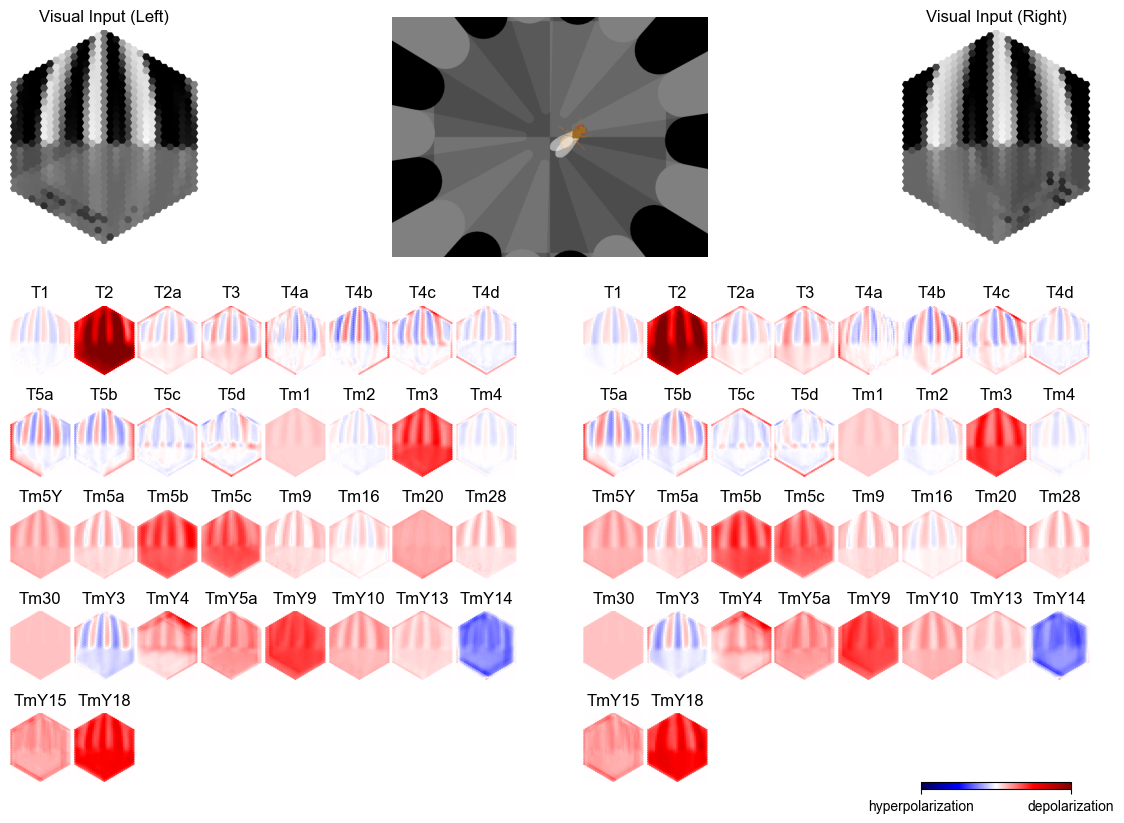

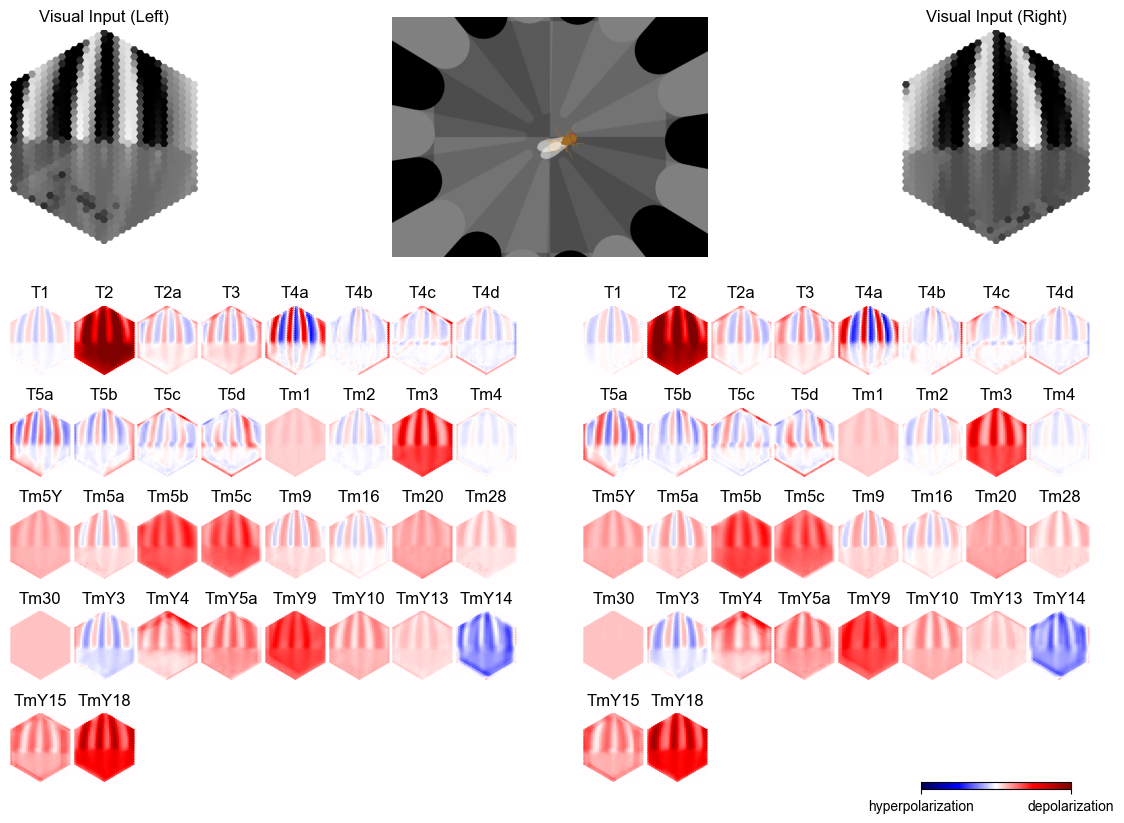

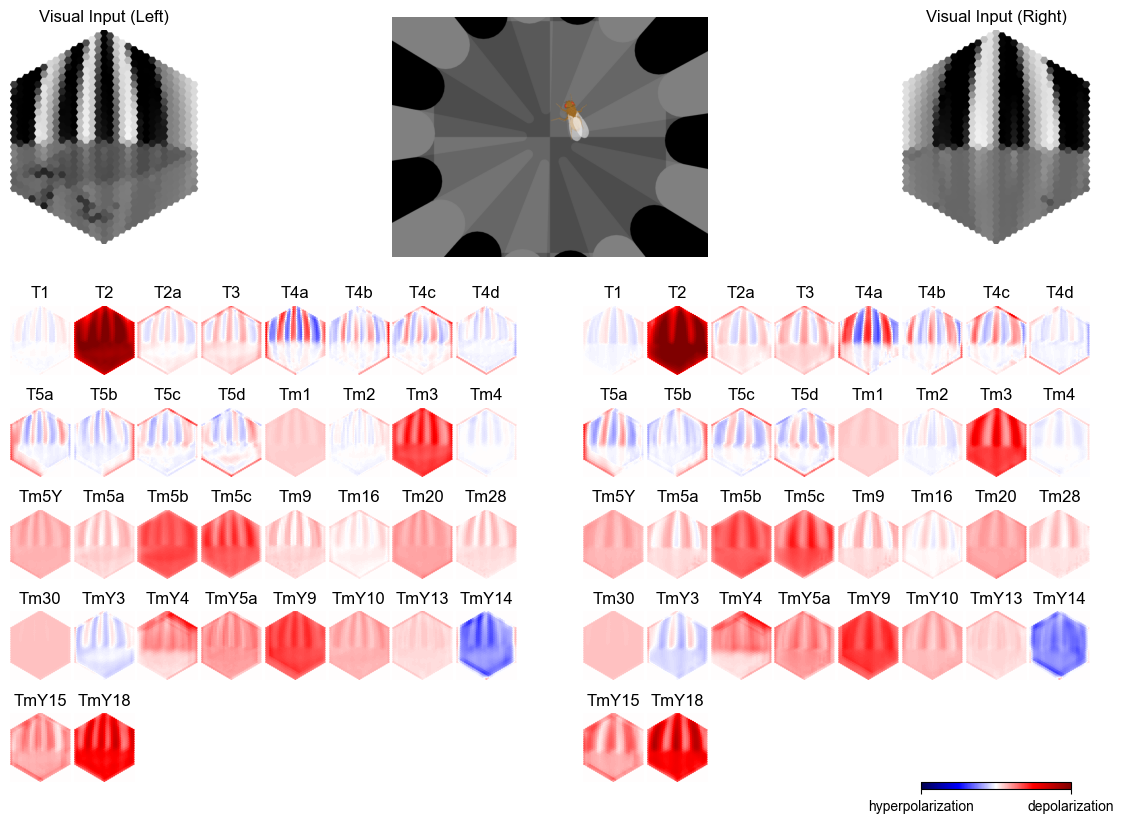

In [5]:
def process_trial(behavior, speed, terrain):
    variation_name = behavior + "_terrain_" + terrain + "_speed_" + str(speed)
    stabilization_model = HeadStabilizationInferenceWrapper(
        model_path=stabilization_model_path,
        scaler_param_path=scaler_param_path,
    )

    if(terrain == "Optomotor"):
        trial_terrain = OptomotorTerrain(ang_speed = speed)
    elif(terrain == "Looming"):
        trial_terrain = LoomingTerrain(move_speed = speed)
    else:
        print("Error while choosing terrain type.")
        return

    # Run simulation
    res = run_simulation(
        fly_behavior = behavior,
        arena=trial_terrain,
        run_time=1.0,
        head_stabilization_model=stabilization_model,
    )

    # Save visualization
    visualize_vision(
        Path(output_dir) / f"{variation_name}.mp4",
        res["sim"].fly.retina,
        res["sim"].retina_mapper,
        rendered_image_hist=res["rendered_image_snapshots"],
        vision_observation_hist=res["vision_observation_snapshots"],
        nn_activities_hist=res["nn_activities_snapshots"],
        fps=res["sim"].cameras[0].fps,
    )

    # Save median and std of response for each cell
    response_stats = {}
    for cell in cells:
        response_all = np.array(
            [info["nn_activities"][cell] for info in res["info_hist"]]
        )
        response_mean = np.mean(response_all, axis=0)
        response_std = np.std(response_all, axis=0)
        response_stats[cell] = {
            "all": res["sim"].retina_mapper.flyvis_to_flygym(response_all),
            "mean": res["sim"].retina_mapper.flyvis_to_flygym(response_mean),
            "std": res["sim"].retina_mapper.flyvis_to_flygym(response_std),
        }
    with open(output_dir / f"{variation_name}_stats.pkl", "wb") as f:
        pickle.dump(response_stats, f)


if __name__ == "__main__":
    output_dir.mkdir(exist_ok=True, parents=True)
    configs = [
        (behavior, speed, terrain)
        # Here are the possibilities to choose from for the behavior and terrain types:
        #  - for behavior: "Immobile", "SimpleSTDT4", "SimpleSTDT5", "AdaptativeSTDT4", "AdaptativeSTDT5","SimpleSTDT45" ,"AdaptativeSTDT45", "RealisticProportional"
        #  - for terrain: "Optomotor", "Looming"
        # It is better to choose a speed that is not too big, 3 seems to be a good value
        for behavior in ["SimpleSTDT4", "SimpleSTDT5"]
        for speed in [3]
        for terrain in ["Optomotor"]
    ]
    # Uncomment the next line and comment the following ones for multi=processing. Requires A LOT of ram, more than 32 Go.
    #Parallel(backend='multiprocessing', n_jobs=9)(delayed(process_trial)(*config) for config in configs)
    
    for config in configs:  
        process_trial(*config)